In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

Step 1: read data

In [2]:
# load data
file_path = 'tokyo_electricity_final_dataset_half_hourly.csv'
data = pd.read_csv(file_path)

# change datetime type
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d %H:%M')

# set datetime as index
data.set_index('datetime', inplace=True)

# view data
print(data.head())

                     price_act  electricity_demand  solar_generation  \
datetime                                                               
2021-01-01 00:00:00      50.00                3184               0.0   
2021-01-01 00:30:00      40.00                3184               0.0   
2021-01-01 01:00:00      37.13                2978               0.0   
2021-01-01 01:30:00      35.00                2978               0.0   
2021-01-01 02:00:00      35.00                2834               0.0   

                     wind_generation  tempc  cloud8  windmps   wdir  rainmm  \
datetime                                                                      
2021-01-01 00:00:00             11.0    0.3     1.0      1.0  310.0    0.04   
2021-01-01 00:30:00             11.0    0.3     1.0      1.0  310.0    0.04   
2021-01-01 01:00:00             13.0    0.0     1.0      1.0  308.0    0.04   
2021-01-01 01:30:00             13.0    0.0     1.0      1.0  308.0    0.04   
2021-01-01 02:00:00  

Step 2: data visualization

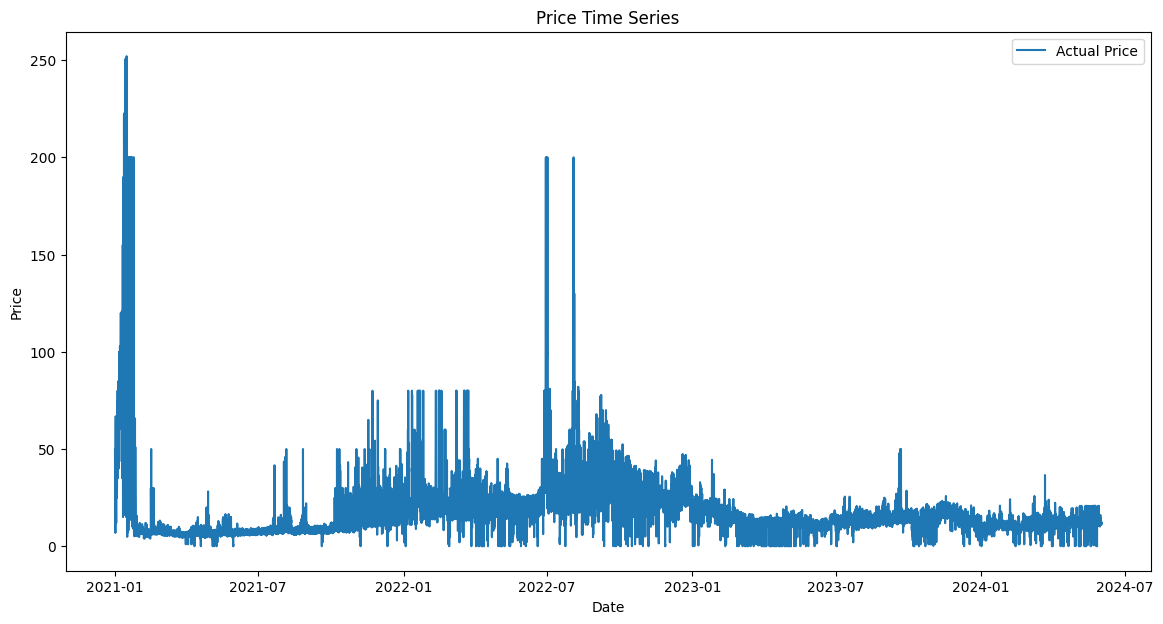

In [3]:
# plot the time series
plt.figure(figsize=(14, 7))
plt.plot(data['price_act'], label='Actual Price')
plt.title('Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [4]:
# float display setting
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# generate structure for final dataset
summary = {'Min': data.min(),
           'Q1 (25th)': data.quantile(0.25),
           'Mean': data.mean(),
           'Median': data.median(),
           'Q3 (75th)': data.quantile(0.75),
           'Max': data.max()
}
df_summary = pd.DataFrame(summary)
print(f"Summary for final dataset:")
display(df_summary)

Summary for final dataset:


,Min,Q1 (25th),Mean,Median,Q3 (75th),Max
price_act,0.01,9.36,17.19,13.42,20.01,252.00
electricity_demand,1855.00,2664.00,3194.92,3116.00,3610.00,5930.00
solar_generation,0.00,0.00,266.89,4.00,449.00,1635.33
wind_generation,0.00,4.00,9.08,7.00,13.00,41.00
tempc,-3.20,9.50,16.38,16.40,23.00,37.20
cloud8,0.00,2.00,4.96,6.00,7.00,8.00
windmps,0.00,1.00,2.73,3.00,4.00,12.00
wdir,0.00,130.00,201.44,180.00,320.00,360.00
rainmm,0.00,0.00,0.19,0.00,0.04,14.25
humid,11.00,53.00,68.24,69.00,85.00,100.00


Step 3: Feature engineering and feature selection

In [5]:
def create_features(df, column_name):
    """Create lag and rolling features for the given column"""
    # df[f'{column_name}_lag1'] = df[column_name].shift(1)
    # df[f'{column_name}_lag14'] = df[column_name].shift(
    #     14)  # 7 days * 2 (half-hourly intervals per day)
    df[f'{column_name}_lag48'] = df[column_name].shift(
        48)  # 48 half-hour per day
    # df[f'{column_name}_rolling_mean'] = df[column_name].rolling(
    #     window=14).mean()
    # df[f'{column_name}_rolling_std'] = df[column_name].rolling(window=14).std()
    df[f'{column_name}_rolling_mean'] = df[column_name].rolling(
        window=12).mean()
    df[f'{column_name}_rolling_std'] = df[column_name].rolling(window=12).std()
    return df

In [6]:
# feature engineering for all columns
for column in data.columns:
    data = create_features(data, column)

# create time features
data['month'] = data.index.month
data['quarter'] = data.index.quarter
data['day_of_week'] = data.index.dayofweek
data['hour'] = data.index.hour
data['minute'] = data.index.minute

# drop rows with NaN values
data.dropna(inplace=True)

# view data after feature engineering
print(data.head())

                     price_act  electricity_demand  solar_generation  \
datetime                                                               
2021-01-02 00:00:00      40.00                2855              0.00   
2021-01-02 00:30:00      37.71                2855              0.00   
2021-01-02 01:00:00      37.13                2715              0.00   
2021-01-02 01:30:00      35.00                2715              0.00   
2021-01-02 02:00:00      35.00                2650              0.00   

                     wind_generation  tempc  cloud8  windmps   wdir  rainmm  \
datetime                                                                      
2021-01-02 00:00:00            12.00   3.40    1.00     1.00 340.00    0.04   
2021-01-02 00:30:00            12.00   3.40    1.00     1.00 340.00    0.04   
2021-01-02 01:00:00            11.00   2.80    1.00     2.00 336.00    0.04   
2021-01-02 01:30:00            11.00   2.80    1.00     2.00 336.00    0.04   
2021-01-02 02:00:00  

In [7]:
# all features as a list for selection
selected_features = ['price_act_lag48', 'price_act_rolling_mean', 'price_act_rolling_std', 'electricity_demand_lag48',  'electricity_demand_rolling_mean', 'electricity_demand_rolling_std',
                     'solar_generation_lag48', 'solar_generation_rolling_mean', 'solar_generation_rolling_std',
                     'wind_generation_lag48', 'wind_generation_rolling_mean', 'wind_generation_rolling_std',
                     'tempc_lag48', 'tempc_rolling_mean', 'tempc_rolling_std',
                     'cloud8_lag48', 'cloud8_rolling_mean', 'cloud8_rolling_std',
                     'windmps_lag48', 'windmps_rolling_mean', 'windmps_rolling_std',
                     'wdir_lag48', 'wdir_rolling_mean', 'wdir_rolling_std',
                     'rainmm_lag48', 'rainmm_rolling_mean', 'rainmm_rolling_std',
                     'humid_lag48', 'humid_rolling_mean', 'humid_rolling_std',
                     'radjcm2_lag48', 'radjcm2_rolling_mean', 'radjcm2_rolling_std',
                     'month', 'quarter', 'day_of_week', 'hour', 'minute']

# split data into X and y
X = data[selected_features]
y = data['price_act']

# select features using Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)
model = SelectFromModel(lasso, prefit=True)
X_selected = model.transform(X)

# print selected features
selected_feature_names = np.array(selected_features)[model.get_support()]
print(f'Selected features: {selected_feature_names}')

Selected features: ['price_act_lag48' 'price_act_rolling_mean' 'price_act_rolling_std'
 'electricity_demand_lag48' 'electricity_demand_rolling_mean'
 'electricity_demand_rolling_std' 'solar_generation_lag48'
 'solar_generation_rolling_mean' 'solar_generation_rolling_std'
 'wind_generation_lag48' 'wind_generation_rolling_mean'
 'wind_generation_rolling_std' 'tempc_lag48' 'tempc_rolling_mean'
 'tempc_rolling_std' 'cloud8_lag48' 'cloud8_rolling_mean'
 'cloud8_rolling_std' 'windmps_lag48' 'windmps_rolling_mean' 'wdir_lag48'
 'wdir_rolling_mean' 'wdir_rolling_std' 'rainmm_lag48'
 'rainmm_rolling_mean' 'humid_lag48' 'humid_rolling_mean'
 'humid_rolling_std' 'radjcm2_lag48' 'radjcm2_rolling_mean'
 'radjcm2_rolling_std' 'month' 'quarter' 'day_of_week' 'hour' 'minute']


c:\Users\LWQ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Step 4: modeling

In [8]:
# split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y, test_size=0.2, random_state=42)

# train XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)

# predict on validation set
y_pred_val = model.predict(X_val)

# evaluate model using RMSE
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f'Validation RMSE: {rmse_val}')

Validation RMSE: 3.2016342055338756


Step 5: Make forecasts based on June data

In [9]:
# load test data(june data)
test_data_path = 'tokyo_june_combined.csv'
test_data = pd.read_csv(test_data_path)

# change datetime type
test_data['datetime'] = pd.to_datetime(
    test_data['datetime'], format='%Y/%m/%d %H:%M')

# set datetime as index
test_data.set_index('datetime', inplace=True)

# feature engineering for all columns
for column in test_data.columns:
    test_data = create_features(test_data, column)

# create time features
test_data['month'] = test_data.index.month
test_data['quarter'] = test_data.index.quarter
test_data['day_of_week'] = test_data.index.dayofweek
test_data['hour'] = test_data.index.hour
test_data['minute'] = test_data.index.minute

# fill missing values in test data
test_data.ffill(inplace=True)
test_data.bfill(inplace=True)

# select features using Lasso
X_test = test_data[selected_features]

# predict on test set using model trained on training set
y_pred_test = model.predict(X_test[selected_feature_names])

# evaluate model using RMSE
rmse_test = np.sqrt(mean_squared_error(test_data['price_act'], y_pred_test))
print(f'Test RMSE: {rmse_test}')

# save predicted prices to a csv file
test_data['predicted_price'] = y_pred_test
test_data[['predicted_price']].to_csv('tokyo_june_predicted_prices.csv')

print("June electricity price forecast has been saved as 'tokyo_june_predicted_prices.csv'")

Test RMSE: 1.4377315177357237
June electricity price forecast has been saved as 'tokyo_june_predicted_prices.csv'
